# Forward Mode Automatic Differentiation

At the heart of modern machine learning, so popular in 2019, is an optimization problem. Optimization means gradients, so suddenly differentiation, especially automatic differentiation (AD), is exciting.

The first time one hears about AD, it is easy to imagine what it is. Surely it is straightforward symbolic differentiation applied to code. One imagines automatically doing what is learned in a calculus class, like
$$ \frac{d}{dx}x^n = n x^{n-1}. $$
**This is not how AD works.**

Ok, then it must be numerical differentiation and to first order
$$ \frac{df}{dx} \approx \frac{f(x+h) - f(x)}{\Delta h} $$
**This is also not how AD works.**

# Babylonian sqrt

> Repeat $t \leftarrow (t + x/2)/2$ until $t$ converges to $\sqrt{x}$.

In [1]:
@inline function Babylonian(x; N = 10)
    t = (1+x)/2
    for i = 2:N
        t = (t + x/t)/2
    end
    t
end

Babylonian (generic function with 1 method)

In [2]:
α = π

Babylonian(α), √α

(1.7724538509055159, 1.7724538509055159)

In [3]:
Babylonian(2), √2

(1.414213562373095, 1.4142135623730951)

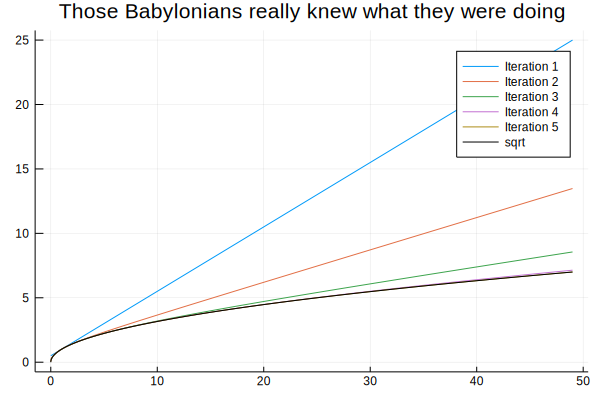

In [8]:
using Plots

xs = 0:0.01:49

p = plot(title = "Those Babylonians really knew what they were doing")
for i in 1:5
    plot!(p, xs, [Babylonian(x; N=i) for x in xs], label="Iteration $i")
end

plot!(p, xs, sqrt.(xs), label="sqrt", color=:black)

# ... and now the derivative, almost by magic

Ten lines of Julia code! No mention of 1/2 over sqrt(x). D for "dual number", invented by Clifford in 1873.

In [9]:
struct D <: Number
    x::Float64 # value
    ϵ::Float64 # derivative
end

import Base: +, /, convert, promote_rule
a::D + b::D = D(a.x + b.x, a.ϵ + b.ϵ) # sum rule
a::D / b::D = D(a.x / b.x, (b.x * a.ϵ - a.x * b.ϵ)/b.x^2) # quotient rule
convert(::Type{D}, x::Real) = D(x, zero(x))
promote_rule(::Type{D}, ::Type{<:Number}) = D

promote_rule (generic function with 145 methods)

The same babylonian algorithm with no rewrite at all computes properly the derivative as the check shows.

In [10]:
Babylonian(D(5, 1)) |> dump

D
  x: Float64 2.23606797749979
  ϵ: Float64 0.22360679774997896


In [11]:
x = 5; Babylonian(D(x, 1)), (√x, 0.5 / √x)

(D(2.23606797749979, 0.22360679774997896), (2.23606797749979, 0.22360679774997896))

In [12]:
x = π; Babylonian(D(x, 1)), (√x, 0.5 / √x)

(D(1.7724538509055159, 0.28209479177387814), (1.7724538509055159, 0.28209479177387814))

### It just works!

In [13]:
code_llvm(Babylonian, (D,); debuginfo=:none)


; Function Attrs: uwtable
define void @julia_Babylonian_18408({ double, double }* noalias nocapture sret, { double, double } addrspace(11)* nocapture nonnull readonly dereferenceable(16)) #0 {
top:
  %2 = getelementptr inbounds { double, double }, { double, double } addrspace(11)* %1, i64 0, i32 0
  %3 = load double, double addrspace(11)* %2, align 8
  %4 = fadd double %3, 1.000000e+00
  %5 = getelementptr inbounds { double, double }, { double, double } addrspace(11)* %1, i64 0, i32 1
  %6 = load double, double addrspace(11)* %5, align 8
  %7 = fadd double %6, 0.000000e+00
  %8 = fmul double %4, 5.000000e-01
  %9 = fmul double %7, 2.000000e+00
  %10 = fmul double %4, 0.000000e+00
  %11 = fsub double %9, %10
  %12 = fmul double %11, 2.500000e-01
  %13 = fdiv double %3, %8
  %14 = fmul double %8, %6
  %15 = fmul double %12, %3
  %16 = fsub double %14, %15
  %17 = fmul double %8, %8
  %18 = fdiv double %16, %17
  %19 = fadd double %8, %13
  %20 = fadd double %12, %18
  %21 = fmul double 

# Symbolically

It may be of some value to understand that the below is mathematically equivalent, though not what the computation is doing.

In [17]:
using SymPy

In [18]:
x = symbols("x")

display("Iterations as a function of x")
for k = 1:5
    display(simplify(Babylonian(x; N=k)))
end

display("Derivatives as a function of x")
for k = 1:5
    display(simplify(diff(simplify(Babylonian(x; N=k)), x)))
end

"Iterations as a function of x"

x   1
- + -
2   2

           2
    (x + 1) 
x + --------
       4    
------------
   x + 1    

 4       3       2           
x  + 28*x  + 70*x  + 28*x + 1
-----------------------------
     / 3      2          \   
   8*\x  + 7*x  + 7*x + 1/   

 8        7         6         5          4         3         2            
x  + 120*x  + 1820*x  + 8008*x  + 12870*x  + 8008*x  + 1820*x  + 120*x + 1
--------------------------------------------------------------------------
         / 7       6        5        4        3        2           \      
      16*\x  + 35*x  + 273*x  + 715*x  + 715*x  + 273*x  + 35*x + 1/      

 16        15          14           13             12             11          
x   + 496*x   + 35960*x   + 906192*x   + 10518300*x   + 64512240*x   + 2257928
------------------------------------------------------------------------------
               / 15        14         13           12           11            
            32*\x   + 155*x   + 6293*x   + 105183*x   + 876525*x   + 4032015*x

    10              9              8              7              6            
40*x   + 471435600*x  + 601080390*x  + 471435600*x  + 225792840*x  + 64512240*
------------------------------------------------------------------------------
10             9             8             7             6            5       
   + 10855425*x  + 17678835*x  + 17678835*x  + 10855425*x  + 4032015*x  + 8765

 5             4           3          2            
x  + 10518300*x  + 906192*x  + 35960*x  + 496*x + 1
---------------------------------------------------
    4           3         2            \           


"Derivatives as a function of x"

1/2

   2            
  x  + 2*x + 5  
----------------
  / 2          \
4*\x  + 2*x + 1/

 6       5        4        3        2             
x  + 14*x  + 147*x  + 340*x  + 375*x  + 126*x + 21
--------------------------------------------------
  / 6       5       4        3       2           \
8*\x  + 14*x  + 63*x  + 100*x  + 63*x  + 14*x + 1/

 14       13         12          11           10            9            8    
x   + 70*x   + 3199*x   + 52364*x   + 438945*x   + 2014506*x  + 5430215*x  + 8
------------------------------------------------------------------------------
      / 14       13         12          11           10           9           
   16*\x   + 70*x   + 1771*x   + 20540*x   + 126009*x   + 440986*x  + 920795*x

        7            6            5            4           3          2       
836200*x  + 8842635*x  + 5425210*x  + 2017509*x  + 437580*x  + 52819*x  + 3094
------------------------------------------------------------------------------
8            7           6           5           4          3         2       
  + 1173960*x  + 920795*x  + 440986*x  + 126009*x  + 20540*x  + 1771*x  + 70*x

       
*x + 85
-------
    \  
 + 1/  

 30        29          28            27              26               25      
x   + 310*x   + 59799*x   + 4851004*x   + 215176549*x   + 5809257090*x   + 102
------------------------------------------------------------------------------
                     / 30        29          28            27             26  
                  32*\x   + 310*x   + 36611*x   + 2161196*x   + 73961629*x   +

           24                  23                   22                   21   
632077611*x   + 1246240871640*x   + 10776333438765*x   + 68124037776390*x   + 
------------------------------------------------------------------------------
             25                24                 23                  22      
 1603620018*x   + 23367042639*x   + 238538538360*x   + 1758637118685*x   + 957

                 20                     19                     18             
321156247784955*x   + 1146261110726340*x   + 3133113888931089*x   + 6614351291
--------------------------------------------------

How does AD get the answer?

Note that we can rewrite our algorithm by taking the derivative of every operation to obtain the correct result.

In [19]:
function dBabylonian(x; N=10)
    t = (1+x)/2
    dt = 1/2
    for i = 2:N
        t = (t + x/t)/2
        dt = (dt + (t-x*dt)/t^2)/2;
    end
    dt
end

dBabylonian (generic function with 1 method)

In [20]:
dBabylonian(5), 0.5/√5

(0.22360679774997896, 0.22360679774997896)

So, basically the trick is for the computer system to do the rewrite for you, without any loss of speed or convenience.

Important: The derivative is substituted *before* the JIT compilation, and thus efficient compiled code is executed.

# ForwardDiff.jl

In [21]:
# utility function for our small forward AD
derivative(f::Function, x::Number) = f(D(x, one(x))).ϵ

derivative (generic function with 1 method)

In [22]:
derivative(Babylonian, 2)

0.35355339059327373

In [23]:
derivative(x -> 1/x, 4), -1/4^2

(-0.0625, -0.0625)

Now that we have understood how forward AD works, we can use the more feature complete package [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl).

In [25]:
using ForwardDiff

In [26]:
ForwardDiff.derivative(Babylonian, 2)

0.35355339059327373

In [27]:
@edit ForwardDiff.derivative(Babylonian, 2)

(Note: [DiffRules.jl](https://github.com/JuliaDiff/DiffRules.jl))

**Example**: pressure = - d/dV(free energy)

# Some nice reads

Blog posts:

* ML in Julia: https://julialang.org/blog/2018/12/ml-language-compiler

* Nice example: https://fluxml.ai/2019/03/05/dp-vs-rl.html

* Nice interactive examples: https://fluxml.ai/experiments/

* Why Julia for ML? https://julialang.org/blog/2017/12/ml&pl

* Neural networks with differential equation layers: https://julialang.org/blog/2019/01/fluxdiffeq

* Implement Your Own Automatic Differentiation with Julia in ONE day : http://blog.rogerluo.me/2018/10/23/write-an-ad-in-one-day/

* Implement Your Own Source To Source AD in ONE day!: http://blog.rogerluo.me/2019/07/27/yassad/

Repositories:

* AD flavors, like forward and reverse mode AD: https://github.com/MikeInnes/diff-zoo (Mike is one of the smartest Julia ML heads)

Talks:

* AD is a compiler problem: https://juliacomputing.com/assets/pdf/CGO_C4ML_talk.pdf